In [42]:
#Global Imports
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy

# Load Data from Bugzilla (REST)

Here's a link to the [Bugzilla URL for Papyrus](https://bugs.eclipse.org/bugs/buglist.cgi?bug_status=UNCONFIRMED&bug_status=NEW&bug_status=ASSIGNED&bug_status=REOPENED&limit=0&list_id=17376363&order=priority%2Cbug_severity&product=Papyrus&query_format=advanced) (filtered on open bugs):

First we need to request the data based on our Bugzilla query. The initial response will only include overall bug information, so to retrieve the full bug text (with comments), an additional request is made for each bug.

We'll create a few arrays of data based on the bugs:
1. bug_ids - the text id of the bug
2. bug_titles - the title of the bug
3. bug_products - the product listed for the bug
4. bug_components - the component listed for the bug
5. bug_text - a concatenation of all of the text (including comments) entered for the bug

In [43]:
import requests

# Remove the limit=10 after debugging errors. Beware of rate limits. Eclipse Bugzilla automatically limits to 2000
resp = requests.get('https://bugs.eclipse.org/bugs/rest/bug?limit=10&product=Papyrus&bug_status=UNCONFIRMED&bug_status=NEW&bug_status=ASSIGNED&bug_status=REOPENED')
if resp.status_code != 200:
    # This means something went wrong.
    raise ApiError('GET /tasks/ {}'.format(resp.status_code))

bugs = resp.json()

bug_ids = []
bug_titles = []
bug_products = []
bug_components = []
bug_text = []

def getComments(id):
    url = 'https://bugs.eclipse.org/bugs/rest/bug/'+str(id)+'/comment'
    resp = requests.get(url)
    if resp.status_code != 200:
        # This means something went wrong.
        raise ApiError('GET /tasks/ {}'.format(resp.status_code))
    response = resp.json()
    
    text = ' '
    for comment in response['bugs'][str(id)]['comments']:
        text += ' '+ comment['text']
    return text
    
for bug in bugs['bugs']:
    id = bug['id']
    bug_ids.append(id)
    
    summary = bug['summary']
    bug_titles.append(summary)
    product = bug['product']
    bug_products.append(product)
    
    component = bug['component']
    bug_components.append(component)
    
    text = summary + getComments(id)
    bug_text.append(text);    


# Load Data from Bugzilla (XML)

Here's a link to the [Bugzilla URL for Papyrus](https://bugs.eclipse.org/bugs/buglist.cgi?bug_status=UNCONFIRMED&bug_status=NEW&bug_status=ASSIGNED&bug_status=REOPENED&limit=0&list_id=17376363&order=priority%2Cbug_severity&product=Papyrus&query_format=advanced) (filtered on open bugs):

First we need to load the data from the XML file that we downloaded from our Bugzilla query. We'll create a few arrays of data based on the bugs:
1. bug_ids - the text id of the bug
2. bug_titles - the title of the bug
3. bug_products - the product listed for the bug
4. bug_components - the component listed for the bug
5. bug_text - a concatenation of all of the text (including comments) entered for the bug

In [2]:
import xml.etree.ElementTree as ET

bug_ids = []
bug_titles = []
bug_products = []
bug_components = []
bug_text = []

tree = ET.parse('/home/jlangley/papyrus_bugs.xml')
root = tree.getroot()
for bug in root:
    
    id = bug.find('bug_id')
    bug_ids.append(id.text)
    
    title = bug.find('short_desc')
    bug_titles.append(title.text)
    
    product = bug.find('product')
    bug_products.append(product.text)
    
    component = bug.find('component')
    bug_components.append(component.text)
    
    text = title.text
    for thetext in bug.iter('thetext'):
        if thetext.text:
            text += ' '+ thetext.text
    for longdesc in bug.iter('long_desc'):
        thetext = longdesc.find('thetext')
        if thetext.text:
            text += ' '+ thetext.text
    bug_text.append(text);    
    
print('Loaded '+str(len(bug_ids))+' bugs')

Loaded 588 bugs


# Create a Tokenize Method
This method provides a simple list of words from the text. We will go ahead and run this against the bugs that we have loaded to find the total number of tokens.


In [44]:
def tokenize(text):
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in text.split(' '):
        if re.fullmatch('[a-zA-Z]+', token):
            filtered_tokens.append(token)
    return filtered_tokens

#totalvocab = []
#for i in bug_text:
#    allwords = tokenize(i)
#    totalvocab.extend(allwords)
#print('Total word count: '+str(len(totalvocab)))
    

# Create a Verb/Noun Tokenize Method

This method provides another step of filtering to return only words that are nouns or verbs. We will go ahead and run this against the bugs that we have loaded to find the total number of noun/verbs.


In [45]:
nlp = spacy.load('en_core_web_sm')
filter = ['VERB', 'NOUN', 'PROPN']
def noun_verb(text):
    filtered_tokens = []
    doc = nlp(text)
    for sent in doc.sents:
        for token in sent:
            if re.fullmatch('[a-zA-Z]+', token.text) and token.pos_ in filter:
                filtered_tokens.append(token.text)
    # filter out tokens not nouns or verbs
    return filtered_tokens

#totalvocab = []
#for i in bug_text:
#    allwords = noun_verb(i)
#    totalvocab.extend(allwords)
#print('Total verb/noun count: '+str(len(totalvocab)))

RuntimeError: Language not supported: en_core_web_sm

# Create a TF/IDF Matrix

We'll use the sklearn TfidfVectorizer to build the matrix. For this case, we will use the noun/verb tokenizer to get a list of words from each bug.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.2,
                                   min_df=0.05,
                                   use_idf=True, 
                                   tokenizer=noun_verb)
#tfidf_vectorizer = TfidfVectorizer(max_df=0.1,
#                                 min_df=0.05, stop_words='english',
#                                 use_idf=True, tokenizer=noun_verb, ngram_range=(1,3))
#tfidf_vectorizer = TfidfVectorizer()

%time tfidf_matrix = tfidf_vectorizer.fit_transform(bug_text) #fit the vectorizer to synopses
tfidf_feature_names = tfidf_vectorizer.get_feature_names()


Wall time: 2min 38s


# Create a CountVectorizer


In [6]:
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, tokenizer=noun_verb)
tf = tf_vectorizer.fit_transform(bug_text)
tf_feature_names = tf_vectorizer.get_feature_names()


In [8]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))


In [9]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

# Run NMF
%time nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf_matrix)

# Run LDA
%time lda = LatentDirichletAllocation(n_components=10, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, tf_feature_names, no_top_words)

Wall time: 119 ms
Wall time: 2.49 s
Topic 0:
user models been elements validation comment feature diagrams could used
Topic 1:
gerrit change merged commit was master check example test method
Topic 2:
stereotype profile applied stereotypes application apply profiles properties creation comment
Topic 3:
property view properties value displayed type tab edit set explorer
Topic 4:
editor ocl editors text constraint allow constraints support open provide
Topic 5:
name version wizard operation defined shall provided example file build
Topic 6:
error exception eclipse message may was following plug plugin stack
Topic 7:
file project files wizard package resource extension import workspace models
Topic 8:
source method target link import exception error issue project explorer
Topic 9:
menu explorer move package context select click example shown elements
Topic 0:
port ports cdo synchronization is connection be scaled repositories model
Topic 1:
is model be diagram line class source can explor

(588, 3)
[ 0.55684041  0.66562435  0.06097718]
(588, 2)
1
2
0
0
0
0
2
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
2
2
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
2
0
1
0
0
0
0
0
0
1
0
0
1
0
2
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
2
0
0
2
1
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
2
1
0
2
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
1
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
2
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
2
0
1
0
0
0
1
0
2
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


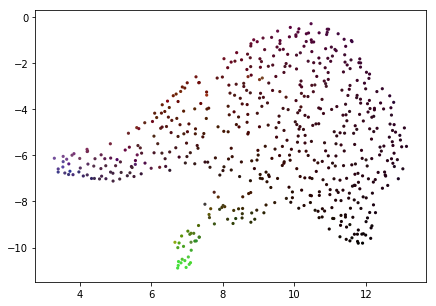

In [37]:
from sklearn.decomposition import TruncatedSVD 
# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=3, algorithm='randomized', n_iter=100, random_state=122) 
svd_model.fit(tfidf_matrix) 
len(svd_model.components_)

import umap 
X_topics = svd_model.fit_transform(tfidf_matrix) 
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics) 

colors = []
for x,y,z in X_topics:
    colors.append((abs(x), abs(y), abs(z)))
    
print(X_topics.shape)
print(X_topics[0, :])
print(embedding.shape)
plt.figure(figsize=(7,5)) 
i = 0;
for em in embedding:
    index = np.argmax(X_topics[i])
    print(index)
    plt.scatter(em[0], em[1],
        c = colors[i],
        s = 10, # size 
        edgecolor='none' )
    i = i+1
plt.show()

# Create a 2D Visualization

Using PCA, create a 2D Visualizaton of the TF/IDF Matrix.

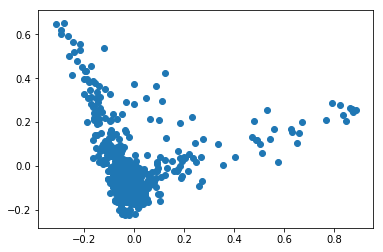

In [46]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

X = tfidf_matrix.todense()

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1])

plt.show()


# I'll have another

Now try the same thing with MDS for reducing to 2 dimensions.

Wall time: 21.9 s


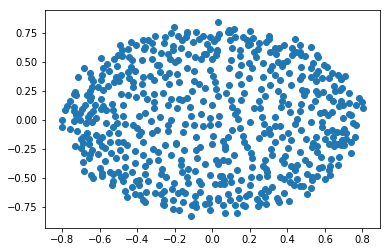

In [47]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

%time pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
plt.scatter(pos[:,0], pos[:,1])

plt.show()
xs, ys = pos[:, 0], pos[:, 1]


# Find Nearest Neighbors

Using the TF/IDF Matrix, find the nearest neighbors for each bug. Print out a random sample with links to spot check. Also plot the distance to the nearest neighbor to visualize the distribution.

Wall time: 998 µs
Check the following bugs for relatedness...
https://bugs.eclipse.org/bugs/show_bug.cgi?id=394888
https://bugs.eclipse.org/bugs/show_bug.cgi?id=290937

https://bugs.eclipse.org/bugs/show_bug.cgi?id=369815
https://bugs.eclipse.org/bugs/show_bug.cgi?id=369810

https://bugs.eclipse.org/bugs/show_bug.cgi?id=329877
https://bugs.eclipse.org/bugs/show_bug.cgi?id=446157

https://bugs.eclipse.org/bugs/show_bug.cgi?id=373604
https://bugs.eclipse.org/bugs/show_bug.cgi?id=297833

https://bugs.eclipse.org/bugs/show_bug.cgi?id=481602
https://bugs.eclipse.org/bugs/show_bug.cgi?id=399267

Distanance to nearest neighbor (Mean/StdDev/Min/Max): (0.90/0.16/0.00/1.00) 


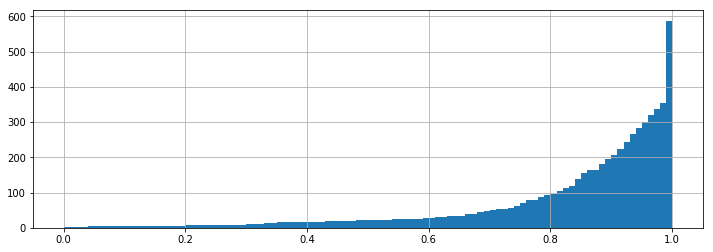

In [49]:
from sklearn.neighbors import NearestNeighbors

%time nbrs = NearestNeighbors().fit(tfidf_matrix)
distances, indices = nbrs.kneighbors(tfidf_matrix)

indicesDF = pd.DataFrame(indices)
sample = indicesDF.sample(5)
print('Check the following bugs for relatedness...')
for row in sample.values:
    print('https://bugs.eclipse.org/bugs/show_bug.cgi?id='+str(bug_ids[row[0]]))
    #print(noun_verb(bug_text[row[0]]))
    print('https://bugs.eclipse.org/bugs/show_bug.cgi?id='+str(bug_ids[row[1]]))
    #print(noun_verb(bug_text[row[1]]))
    print()
distancesDF = pd.DataFrame(distances)

# Slice the distances returned to get the column of the nearest neighbor
nearest = distancesDF.iloc[:, 1]
print('Distanance to nearest neighbor (Mean/StdDev/Min/Max): (%0.2f/%0.2f/%0.2f/%0.2f) ' % (np.mean(nearest), np.std(nearest),
     np.min(nearest), np.max(nearest)))
nearest.hist(cumulative=True, bins=100, figsize=(12, 4));
plt.show()

In [50]:
from sklearn.cluster import KMeans
from sklearn import metrics

num_clusters = 15

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

labels = km.labels_

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(tfidf_matrix, km.labels_, sample_size=1000))



Wall time: 1.74 s
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand-Index: 1.000
Silhouette Coefficient: 0.050


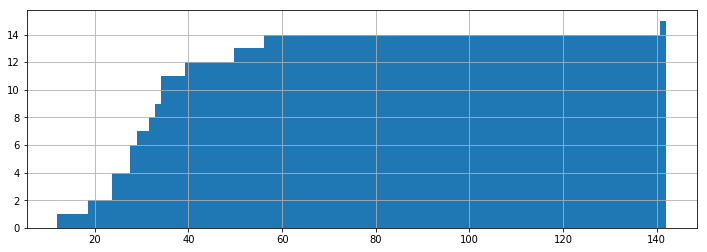

In [51]:
clusters = km.labels_.tolist()
bugs = { 'title': bug_titles, 'text': bug_text, 'cluster': clusters }
frame = pd.DataFrame(bugs, index = [clusters] , columns = ['title', 'cluster'])
frame['cluster'].value_counts().hist(cumulative=True, bins=100, figsize=(12, 4));
plt.show()

In [52]:
print("Top term per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()

top_term = []
for i in range(num_clusters):
    print("Cluster %d:" % i, end='')
    
    for ind in order_centroids[i, :1]:
        print(bug_titles[ind])
        print(terms[ind])
        top_term.append(terms[ind])
        print('https://bugs.eclipse.org/bugs/show_bug.cgi?id='+str(bug_ids[ind]))
        #top_term.append(vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0])
        #print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0])


Top term per cluster:

Cluster 0:[CopyPaste][Model Explorer] copy/paste on interactions does not clone elements !!
branch
https://bugs.eclipse.org/bugs/show_bug.cgi?id=439489
Cluster 1:[RSA] Appearance property "Show Stereotype" not handled for imported model elements in diagrams
elements
https://bugs.eclipse.org/bugs/show_bug.cgi?id=462393
Cluster 2:[UMLTypes] Update to UML2.4 - Fix (event related) EditHelpers
error
https://bugs.eclipse.org/bugs/show_bug.cgi?id=369367
Cluster 3:[print] creation of user defined print format does not work
profile
https://bugs.eclipse.org/bugs/show_bug.cgi?id=354211
Cluster 4:[ProfileDiagram] Cannot establish associations between stereotype and metaclass
ocl
https://bugs.eclipse.org/bugs/show_bug.cgi?id=488668
Cluster 5:Package import fails due to illegalValueException on association nodes
menu
https://bugs.eclipse.org/bugs/show_bug.cgi?id=438596
Cluster 6:[Build] Update the values of the required java version
validation
https://bugs.eclipse.org/bugs/sho

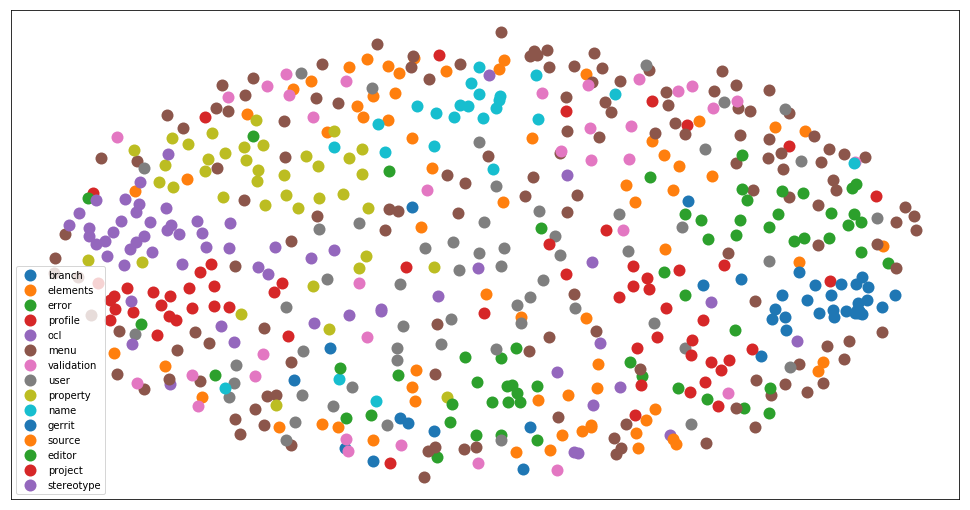

In [53]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=bug_ids)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
#            label=cluster_names[name], color=cluster_colors[name],
#            label=name,
            label=top_term[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the bug id
#for i in range(len(df)):
#    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

plt.show() #show the plot


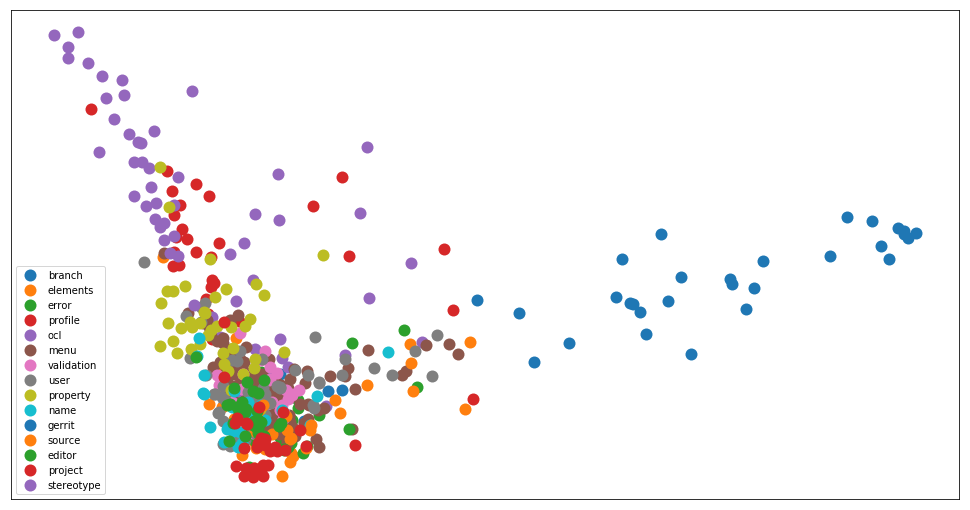

In [54]:
xs, ys = data2D[:, 0], data2D[:, 1]
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=bug_ids)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
#            label=cluster_names[name], color=cluster_colors[name],
#            label=name,
            label=top_term[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the bug id
#for i in range(len(df)):
#    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

plt.show() #show the plot


In [55]:
from sklearn.cluster import DBSCAN

# May be able to calculate this number based on the output from the nearest neighbor search.
# Units relate to the data being fit
epsilon = 0.98


db = DBSCAN(eps=epsilon, min_samples=10)

%time db.fit(tfidf_matrix)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % num_clusters)

Wall time: 20 ms
Estimated number of clusters: 4


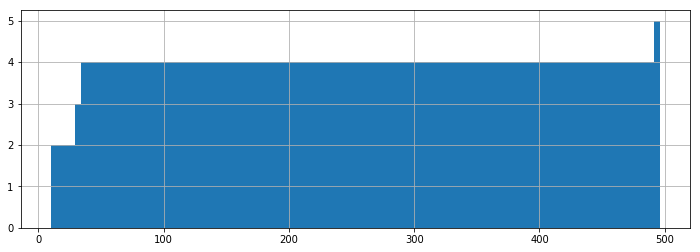

In [56]:
clusters = db.labels_.tolist()
bugs = { 'title': bug_titles, 'text': bug_text, 'cluster': clusters }
frame = pd.DataFrame(bugs, index = [clusters] , columns = ['title', 'cluster'])
frame['cluster'].value_counts().hist(cumulative=True, bins=100, figsize=(12, 4));
plt.show()

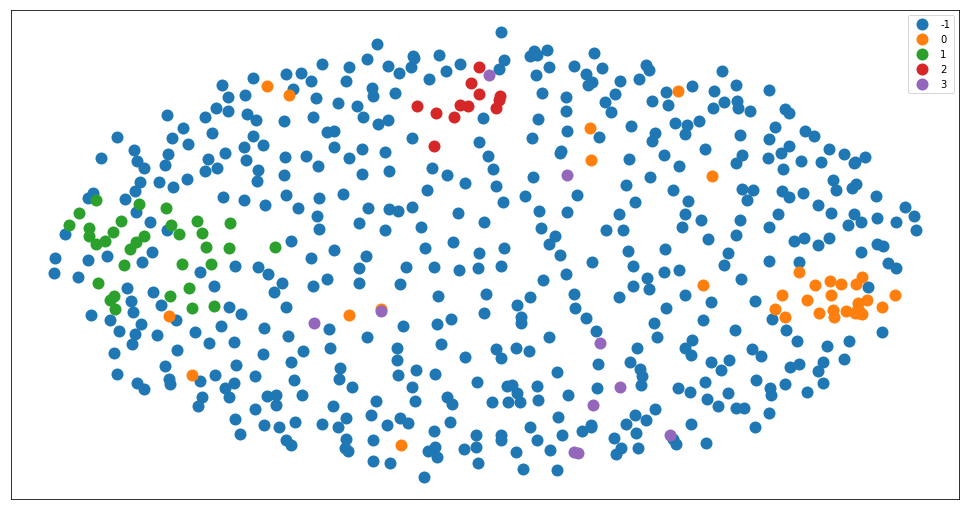

In [57]:
xs, ys = pos[:, 0], pos[:, 1]
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=bug_ids)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
#            label=cluster_names[name], color=cluster_colors[name],
            label=name,
#            label=top_term[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the bug id
#for i in range(len(df)):
#    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

plt.show() #show the plot

In [6]:
#Exception
#doc = nlp(bug_text[2])

#Reply
print(bug_ids[6])
doc = nlp(bug_text[6])
for sent in doc.sents:
    print("Sentence->")
    print(sent)
    if re.match('.+Exception[^\n].*\s+at', str(sent)):
        print('Match!')

435276
Sentence->
[Profiles] Papyrus should not allow to apply the same stereotype twice Created attachment 243285
before applying the stereotype

Steps to reproduce:
- Create a simple SysML model with a requirements table inside
- Add a requirement into the requirements table (see screenshot : before)

- Create a profile that contains a single stereotype that extends the SysML Requirements stereotype, for instance by adding some extra property
- Apply the profile to the model
- Apply the stereotype to the requirement in the model

Result:
Sentence->
The requirements table is now corrupt and contains the error message instead of the original content: "Several stereotypes with this feature are applied -> not yet managed" (see screenshot : after)

Tooling info:
  Papyrus UML (Incubation)	
Sentence->
1.0.0.v201405200454	org.eclipse.papyrus.sdk.feature.feature.group	
Sentence->
Eclipse Modeling Project Created attachment 243286

Sentence->
after applying the stereotype
Sentence->
This does

Sentence->
In that case, I would argue that the problem is not really at the papyrus side, but rather on the side of the UML spec.  
Sentence->
And that this might a drawback of UML profiles.


Sentence->
Side remark: AFAIR Tim Weilkiens does have a Magicdraw version of SysMOD available.  
Sentence->
Do you know how it is implemented in Magicdraw?
Sentence->
Created attachment 250572
MagicDraw SYSMOD (
Sentence->
In reply to Klaas Gadeyne from comment #7)
>
Sentence->
Hi Thomas,
> 
> (In reply to Tomas Sandkvist from comment #6)
> > Just checking, is this to be closed and is the recommended way to go as

Sentence->
> > described:
> > 
> > ...
Sentence->
It seems like the best way to achieve this  SysML-based-DSL in papyrus is
> > to create a new stereotype that directly extends the meta-class Class, and

Sentence->
> > has an OCL constraint stating that its base_Class also should have the
> > Requirement stereotype set.

Sentence->
> >
Sentence->
In this way, there's no need (at the "c

>
Sentence->
>
Sentence->
I've had a quick look, but it's hard to draw conclusions from this online

Sentence->
> > visualisation.  
Sentence->
I was trying to find out if the Car Access System, (which
> > has the <<System>> Stereotype applied that generalizes <<Block>>) also would
> > have the <<Block>
Sentence->
> stereotype applied.  
Sentence->
Unfortunately, I cannot conclude

Sentence->
> > anything from the diagrams, for instance

Sentence->
> > http://example.system-modeling.com/
> > #Package___15_1_3c00182_1208274398703_434904_4794
Sentence->
only _shows_ the
> > <<system>> stereotype, but that doesn't mean that the <<block>> stereotype

Sentence->
> > is not applied however.  
Sentence->
So far, it's inconclusive to me (I'll have to check
>
Sentence->
> it
Sentence->
when I get into the office and get my hands on the MD license)

Magicdraw seems to get it fairly right:

Sentence->
1/
Sentence->
The SysMOD profile in Magicdraw comes in the form of a SysMOD plugin.  
Sentence->


Sentence->
>
Sentence->
I just started realising this myself.  
Sentence->
It seems like the best way to achieve
> this  SysML-based-DSL in papyrus is to create a new stereotype that directly
> extends the meta-class Class, and has an OCL constraint stating that its
> base_Class also should have the Requirement stereotype set.

Sentence->
>
Sentence->
In this way, there's no need (at the "cost" of having two stereotypes)


Sentence->
Hmm, the mid-air collision also ate the rest of this sentence it seems :-(


Sentence->
This should have read:

Sentence->
In this way, there's no need to _re_create all the nice SysML customization stuff and one can reuse the SysML requirements table (at the "cost" of having two stereotypes)


Sentence->
> Let's close this one, although to say the least corrupting the table is a
> weird way of saying to the user that he's followed the wrong path here...
Sentence->
Just checking, is this to be closed and is the recommended way to go as described:

...
Sen


Sentence->
> 

Sentence->
>
Sentence->
Hi Klaas!

Sentence->
> 

Sentence->
>
Sentence->
It appears to be through extension, see attachment.
Sentence->
Found at
>
Sentence->
http://example.system-modeling.com/
>
Sentence->
#Diagrams___17_0_4_2_3c00182_1383042645268_401693_14948


Sentence->
I've had a quick look, but it's hard to draw conclusions from this online visualisation.  
Sentence->
I was trying to find out if the Car Access System, (which has the <<System>>
Sentence->
Stereotype applied that generalizes <<Block>>) also would have the <<Block>> stereotype applied.  
Sentence->
Unfortunately, I cannot conclude anything from the diagrams, for instance http://example.system-modeling.com/#Package___15_1_3c00182_1208274398703_434904_4794
Sentence->
only _shows_ the <<system>> stereotype, but that doesn't mean that the <<block>> stereotype is not applied however.  
Sentence->
So far, it's inconclusive to me (I'll have to check it when I get into the office and get my hands on the MD